In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
data = pd.read_csv('/content/diamonds.csv')

In [3]:
data = data.drop('Unnamed: 0', axis=1)

In [4]:
features = data.copy()
target = data.pop('price')

In [5]:
features.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
#doing ordinal encoding on categorical featurs
#since all of cut/color/clarity all function on a spectrum
cut_cats = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_cats = ['J', 'I', 'H', 'G','F', 'E', 'D']
clarity_cats = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

ordinal_encoder = OrdinalEncoder(categories = [cut_cats, color_cats, clarity_cats])
features[['cut', 'color', 'clarity']] = ordinal_encoder.fit_transform(features[['cut', 'color', 'clarity']])

print(features.head())

   carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23  4.0    5.0      1.0   61.5   55.0    326  3.95  3.98  2.43
1   0.21  3.0    5.0      2.0   59.8   61.0    326  3.89  3.84  2.31
2   0.23  1.0    5.0      4.0   56.9   65.0    327  4.05  4.07  2.31
3   0.29  3.0    1.0      3.0   62.4   58.0    334  4.20  4.23  2.63
4   0.31  1.0    0.0      1.0   63.3   58.0    335  4.34  4.35  2.75


In [7]:
#train-val-test split, ratio of 70:15:15
SEED = 430149

x_train, x_iter, y_train, y_iter = train_test_split(features, target, test_size = 0.3, 
                                                    random_state = SEED)
x_val, x_test, y_val, y_test = train_test_split(x_iter, y_iter, test_size = 0.5,
                                                random_state = SEED)

In [8]:
#standardise data
ss = StandardScaler()

ss.fit(x_train)

x_train = ss.transform(x_train)
x_val = ss.transform(x_val)
x_test = ss.transform(x_test)

In [9]:
#create feed-forward neural network

model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape = x_train.shape[-1]))
model.add(tf.keras.layers.Dense(128,activation='elu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(32,activation='elu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',loss='mse',metrics=['mae','mse'])

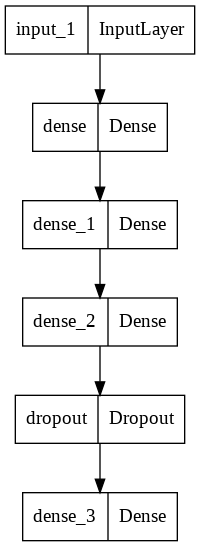

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
#train and evaluate model with validation data

log_path = os.path.join("/content/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=2)

EPOCHS = 100
BATCH_SIZE=64

history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[tb_callback,es_callback])

Epoch 1/100
590/590 [==============================] - 3s 4ms/step - loss: 10510379.0000 - mae: 2046.9822 - mse: 10510379.0000 - val_loss: 1451093.6250 - val_mae: 861.4315 - val_mse: 1451093.6250
Epoch 2/100
590/590 [==============================] - 2s 3ms/step - loss: 1538887.6250 - mae: 828.7902 - mse: 1538887.6250 - val_loss: 409325.0938 - val_mae: 341.9013 - val_mse: 409325.0938
Epoch 3/100
590/590 [==============================] - 2s 3ms/step - loss: 1105189.0000 - mae: 625.2808 - mse: 1105189.0000 - val_loss: 119921.2969 - val_mae: 187.5220 - val_mse: 119921.2969
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 1083614.2500 - mae: 610.4601 - mse: 1083614.2500 - val_loss: 192023.6719 - val_mae: 262.6857 - val_mse: 192023.6719
Epoch 5/100
590/590 [==============================] - 3s 5ms/step - loss: 1059127.3750 - mae: 599.8449 - mse: 1059127.3750 - val_loss: 102142.7344 - val_mae: 149.5085 - val_mse: 102142.7344
Epoch 6/100
590/590 [===================

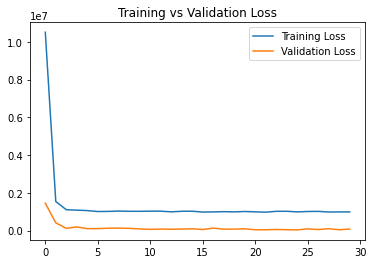

<Figure size 432x288 with 0 Axes>

In [12]:
#plot loss over training
training_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = history.epoch

plt.plot(epoch, training_loss, label='Training Loss')
plt.plot(epoch, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.figure()
plt.savefig(os.path.join("/content/","loss.png"),bbox_inches='tight')
plt.show()

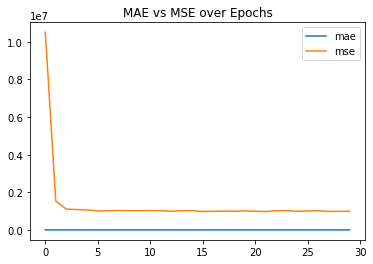

<Figure size 432x288 with 0 Axes>

In [13]:
mae = history.history['mae']
mse = history.history['mse']

plt.plot(epoch, mae, label='mae')
plt.plot(epoch, mse, label = 'mse')
plt.title('MAE vs MSE over Epochs')
plt.legend()
plt.figure()
plt.savefig(os.path.join("/content/","accuracy.png"),bbox_inches='tight')
plt.show()

In [14]:
#evaluate model with test data
test_result = model.evaluate(x_test,y_test,batch_size=BATCH_SIZE)
print(f"Test loss = {test_result[0]}")
print(f"Test MAE = {test_result[1]}")
print(f"Test MSE = {test_result[2]}")

127/127 [==============================] - 1s 6ms/step - loss: 52699.3008 - mae: 158.6764 - mse: 52699.3008
Test loss = 52699.30078125
Test MAE = 158.6764373779297
Test MSE = 52699.30078125


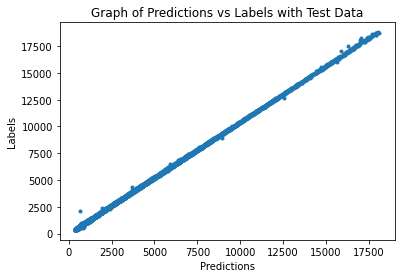

In [15]:
#plot graph of prediction vs label on test data

predictions = np.squeeze(model.predict(x_test))
labels = np.squeeze(y_test)

plt.plot(predictions,labels,".")
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Graph of Predictions vs Labels with Test Data")
plt.savefig(os.path.join("/content/","result.png"),bbox_inches='tight')
plt.show()